In [52]:
import torch


from models.configurations import TEXT_PRETRAINED, VISION_PRETRAINED
from models.adaptor import Adaptor
from models.segmenter import AdaptorSegmenter
from models.seg_models import ResNetAEUNet, DINOv2Segmenter
from utils.model_utils import get_newest_ckpt
from dataset.dataset import clf_collator
from dataset.configurations import DATASET_CFG
from dataset.data_module import AdaptorDataModule
from utils.model_utils import load_vision_model

import numpy as np

In [93]:
vision_model = "resnet-ae"
text_model = "bert"
dataset = "siim"
crop_size = 896

vision_model_config = VISION_PRETRAINED[vision_model]
vision_pretrained = vision_model_config["pretrained_weight"]
vision_model_type = vision_model_config["vision_model_type"]

dataset_cfg = DATASET_CFG["seg"][dataset]
dataset_class = dataset_cfg["class"]
dataset_kwargs = dataset_cfg["kwargs"]
data_transform = vision_model_config["data_transform"]

In [94]:
adaptor_ckpt = get_newest_ckpt(
    vision_model, text_model, postfix="v2", 
    project_name="adaptor_pretrain_2_layers", 
)

adaptor = Adaptor.load_from_checkpoint(adaptor_ckpt)

if vision_model == "resnet-ae":
    seg_model = ResNetAEUNet(
        adaptor=adaptor,
        pretrained=False,
        out_channels=1,
        freeze_adaptor=True,
        input_size=crop_size,
    )

elif vision_model.startswith("dinov2-"):
    backbone = load_vision_model(
        vision_model_type=vision_model_type,
        vision_pretrained=vision_pretrained,
        retain_head=False,
    )
    seg_model = DINOv2Segmenter(
        backbone=backbone,
        adaptor=adaptor,
        hidden_dim=adaptor.projection_dim,
        out_channels=1,
        features=[512, 256, 128, 64],
        freeze_adaptor=True,
        input_size=crop_size,
    )

In [106]:
ckpt = "/vol/bitbucket/jq619/individual-project/trained_models/segment/resnet-ae_biobert_siim_1.0/adaptor_segment_2_layers_siim/ge6e3etc/checkpoints/epoch=41-step=9617.ckpt"

model = AdaptorSegmenter(
    seg_model=seg_model,
    adaptor=adaptor,
)
model.load_from_checkpoint(ckpt, seg_model=seg_model)

AdaptorSegmenter(
  (model): ResNetAEUNet(
    (block1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block2): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu)

In [66]:
import pydicom
import cv2
from PIL import Image
from torchvision.transforms.functional import rgb_to_grayscale
from albumentations import Compose, Normalize, Resize, ShiftScaleRotate, ToGray

from albumentations.pytorch import ToTensorV2

def get_transforms(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), 
                   imsize=224, split="test"):
    list_transforms = []
    if split == "train":
        list_transforms.extend(
            [
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10,  # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT,
                )
            ]
        )
    list_transforms.extend(
        [
            Resize(imsize, imsize),
            Normalize(mean=mean, std=std, p=1),
            ToTensorV2(),
        ],
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

img_path = '/vol/bitbucket/jq619/individual-project/MGCA/mgca/../../data/pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2230.1517875171.729019/1.2.276.0.7230010.3.1.3.8323329.2230.1517875171.729018/1.2.276.0.7230010.3.1.4.8323329.2230.1517875171.729020.dcm'
dcm = pydicom.read_file(img_path)
x = dcm.pixel_array
x = cv2.convertScaleAbs(x, alpha=(255.0 / x.max()))

if dcm.PhotometricInterpretation == "MONOCHROME1":
    x = cv2.bitwise_not(x)

img = Image.fromarray(x).convert("RGB")
x = np.asarray(img)

In [113]:
x, y = np.load("x.npy"), np.load("y.npy")
img_path = '/vol/bitbucket/jq619/individual-project/MGCA/mgca/../../data/pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.5741.1517875190.56469/1.2.276.0.7230010.3.1.3.8323329.5741.1517875190.56468/1.2.276.0.7230010.3.1.4.8323329.5741.1517875190.56470.dcm'

In [115]:
import pydicom

dcm = pydicom.read_file(img_path)
img = dcm.pixel_array

In [123]:
Image.fromarray(img).convert("RGB").resize((896,896)).save("test.png")

In [172]:
from matplotlib import cm

im = Image.fromarray(np.uint8(cm.gist_heat(y)*255))
im = im.resize((896, 896))
im.save('mask.png')

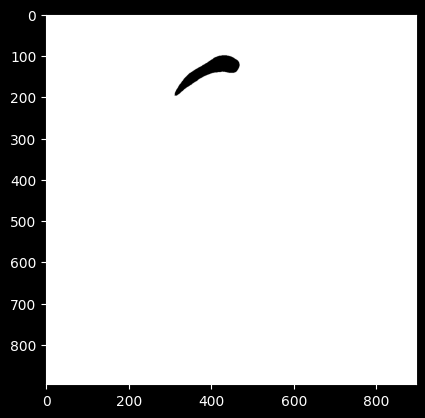

In [163]:
import matplotlib.pyplot as plt

cmap = 'Greys'
plt.imshow(y, cmap=cmap)
plt.savefig('mask.png')

In [164]:
logits = model.model(torch.from_numpy(x).unsqueeze(0))
prob = torch.sigmoid(logits.squeeze(1)).detach().cpu().numpy()[0]

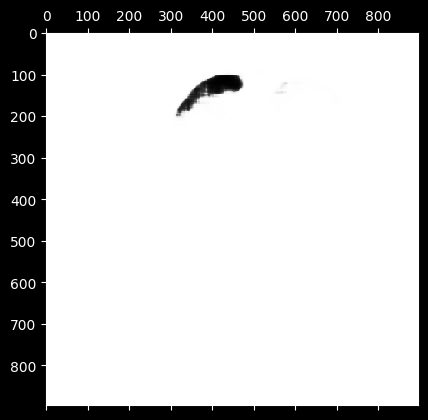

In [171]:
pred = Image.fromarray(np.uint8(cm.gist_heat(prob)*255))
pred = pred.resize((896, 896))
pred.save('pred.png')

plt.matshow(prob, cmap=cmap)
# plt.savefig("pred.png")